In [8]:
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate # Import layers from tensorflow.keras.layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow as tf

In [9]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH ='/content/drive/MyDrive/U_NET/train'
TEST_PATH ='/content/drive/MyDrive/U_NET/validation'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

#### Collect file names for training and test date

In [11]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

#### Creating image masks of dimension 128 x 128 (black images)

In [13]:
# # Illustrate the train images and masks
# print('Getting and resizing train images and masks ... ')
# X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

# sys.stdout.flush()
# for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
#     path = TRAIN_PATH
#     img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_train[n] = img
#     mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

#     for mask_file in next(os.walk(path + '/masks/'))[2]:
#         mask_ = imread(path + '/masks/' + mask_file)
#         mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
#                                       preserve_range=True), axis=-1)
#         mask = np.maximum(mask, mask_)

#     Y_train[n] = mask

# X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# sizes_test = []
# print('Getting and resizing test images ... ')
# sys.stdout.flush()

# for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
#     path = TEST_PATH + id_
#     img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
#     sizes_test.append([img.shape[0], img.shape[1]])
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_test[n] = img

# print('Done!')

# Illustrate the train images and masks
print('Getting and resizing train images and masks ... ')
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + '/' + id_  # Add '/' and id_ to create correct path to image
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

    for mask_file in next(os.walk(path + '/masks/'))[2]: #Changed path to mask
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)

    Y_train[n] = mask

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + '/' + id_ # Add '/' and id_ to create correct path to image
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [1:50:45<00:00,  9.92s/it]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:27<00:00,  2.36it/s]

Done!


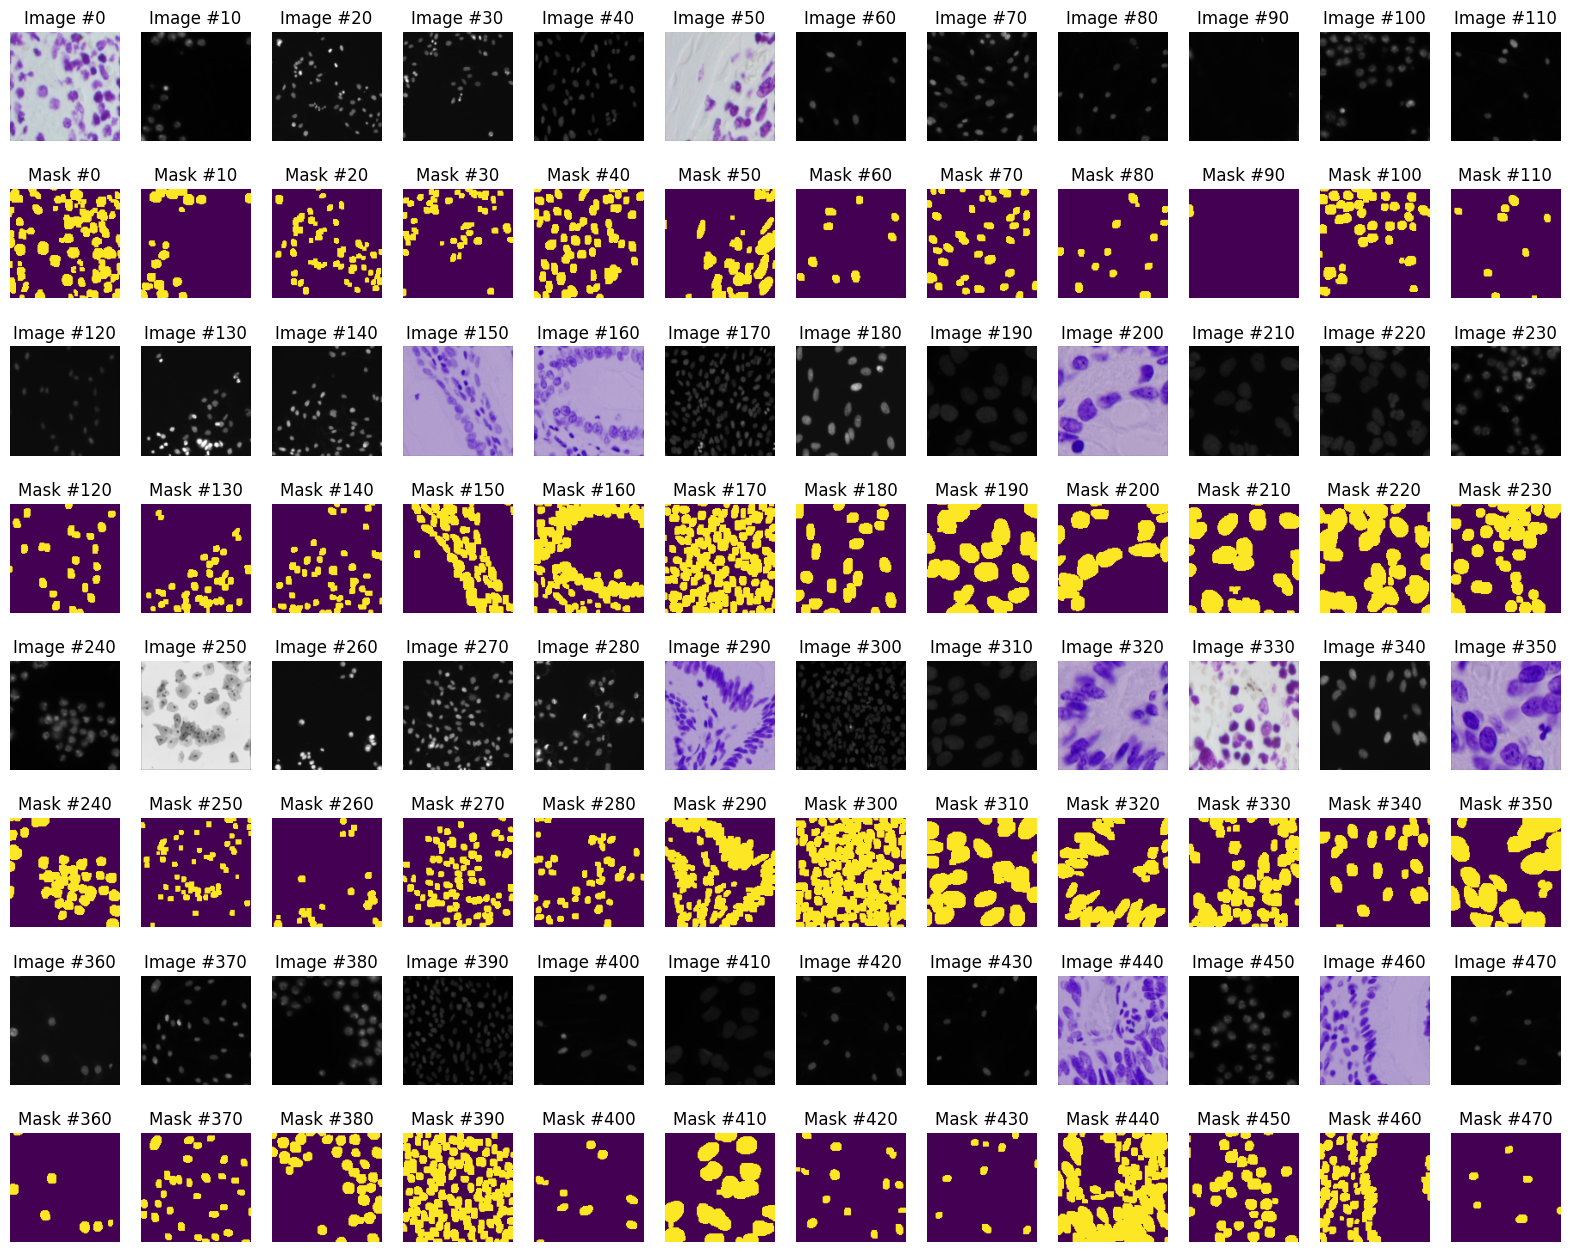

In [14]:
plt.figure(figsize=(20,16))
x, y = 12, 4
for i in range(y):
  for j in range(x):
    plt.subplot(y*2, x, i*2*x+j+1)
    pos = i*120 + j*10
    plt.imshow(X_train[pos])
    plt.title('Image #{}'.format(pos))
    plt.axis('off')
    plt.subplot(y*2, x, (i*2+1)*x+j+1)

    plt.imshow(np.squeeze(Y_train[pos]))
    plt.title('Mask #{}'.format(pos))
    plt.axis('off')
plt.show()

### Define a custom Metric called Intersection over Union (IoU)

In [25]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    # Convert inputs to NumPy arrays to avoid TensorFlow operations
    y_true_in = y_true_in.numpy()
    y_pred_in = y_pred_in.numpy()

    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))
    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Prescision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    # The following line was added to ensure the output shape is defined.
    return np.array(np.mean(metric), dtype=np.float32).reshape(1) # Reshape to (1,) to define the output shape

def my_iou_metric(label, pred):
    metric_value = tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    # The following line was added to specify the output shape.
    metric_value.set_shape([1]) # Set shape to (1,)
    return metric_value

### Building our U-Net Model

In [26]:
# inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
# s = Lambda(lambda x: x / 255) (inputs)

# c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
# c1 = Dropout(0.1)(c1)
# c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
# p1 = MaxPooling2D((2, 2)) (c1)

# c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
# c2 = Dropout(0.1)(c2)
# c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
# p2 = MaxPooling2D((2, 2)) (c2)

# c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
# c3 = Dropout(0.2)(c3)
# c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
# p3 = MaxPooling2D((2, 2)) (c3)

# c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
# c4 = Dropout(0.2)(c4)
# c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
# p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

# c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
# c5 = Dropout(0.3)(c5)
# c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

# u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
# u6 = concatenate([u6, c4])
# c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
# c6 = Dropout(0.2)(c6)
# c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

# u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
# u7 = concatenate([u7, c3])
# c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
# c7 = Dropout(0.2)(c7)
# c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

# u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
# u8 = concatenate([u8, c2])(c8)
# c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)

# u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
# u9 = concatenate([u9, c1], axis=3)
# c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
# c9 = Dropout(0.1)(c9)
# c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

# outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

# model = Model(inputs=[inputs], outputs=[outputs])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[my_iou_metric])
# model.summary()

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
# The following line was changed. It was using c8 before it was defined. It should use u8 and c2 as inputs to concatenate.
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[my_iou_metric])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_4 (Lambda)         │ (None, 128, 128, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)        │ (None, 128, 128, 16)   │            448 │ lambda_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_24 (Dropout)      │ (None, 128, 128, 16)   │              0 │ conv2d_52[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_53 (Conv2D)        │ (None, 128, 128, 16)   │          2,320 │ dropout_24[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 64, 64, 16)     │              0 │ conv2d_53[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_54 (Conv2D)        │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_25 (Dropout)      │ (None, 64, 64, 32)     │              0 │ conv2d_54[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_55 (Conv2D)        │ (None, 64, 64, 32)     │          9,248 │ dropout_25[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 32, 32, 32)     │              0 │ conv2d_55[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_56 (Conv2D)        │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_26 (Dropout)      │ (None, 32, 32, 64)     │              0 │ conv2d_56[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ dropout_26[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 16, 16, 64)     │              0 │ conv2d_57[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_27 (Dropout)      │ (None, 16, 16, 128)    │              0 │ conv2d_58[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 16, 16, 128)    │        147,584 │ dropout_27[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16     

 Total params: 1,931,857 (7.37 MB)

 Trainable params: 1,931,857 (7.37 MB)

 Non-trainable params: 0 (0.00 B)

### Fit our model

In [27]:
# Initialize our callbacks
model_path = "/content/drive/MyDrive/U_NET/model.h5"
checkpoint = ModelCheckpoint(model_path, monitor='val_my_iou_metric', verbose=1, save_best_only=True, mode='max')

earlystop = EarlyStopping(monitor='val_my_iou_metric', patience=5, verbose=1, mode='max')
# Fit our model
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[earlystop, checkpoint])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_127']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.5761 - my_iou_metric: 0.0058
Epoch 1: val_my_iou_metric improved from -inf to 0.17169, saving model to /content/drive/MyDrive/U_NET/model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - loss: 0.5737 - my_iou_metric: 0.0064 - val_loss: 0.3875 - val_my_iou_metric: 0.1717
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.2723 - my_iou_metric: 0.1655
Epoch 2: val_my_iou_metric improved from 0.17169 to 0.30606, saving model to /content/drive/MyDrive/U_NET/model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - loss: 0.2716 - my_iou_metric: 0.1665 - val_loss: 0.3143 - val_my_iou_metric: 0.3061
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1885 - my_iou_metric: 0.3002
Epoch 3: val_my_iou_metric improved from 0.30606 to 0.38504, saving model to /content/drive/MyDrive/U_NET/model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - loss: 0.1882 - my_iou_metric: 0.3009 - val_loss: 0.2164 - val_my_iou_metric: 0.3850
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1554 - my_iou_metric: 0.3809
Epoch 4: val_my_iou_metric improved from 0.38504 to 0.44064, saving model to /content/drive/MyDrive/U_NET/model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - loss: 0.1555 - my_iou_metric: 0.3808 - val_loss: 0.1518 - val_my_iou_metric: 0.4406
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1460 - my_iou_metric: 0.4114
Epoch 5: val_my_iou_metric improved from 0.44064 to 0.44570, saving model to /content/drive/MyDrive/U_NET/model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - loss: 0.1460 - my_iou_metric: 0.4115 - val_loss: 0.1537 - val_my_iou_metric: 0.4457
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1433 - my_iou_metric: 0.4149
Epoch 6: val_my_iou_metric did not improve from 0.44570
38/38 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - loss: 0.1430 - my_iou_metric: 0.4154 - val_loss: 0.1190 - val_my_iou_metric: 0.4409
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1251 - my_iou_metric: 0.4505
Epoch 7: val_my_iou_metric improved from 0.44570 to 0.45078, saving model to /content/drive/MyDrive/U_NET/model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - loss: 0.1252 - my_iou_metric: 0.4505 - val_loss: 0.1398 - val_my_iou_metric: 0.4508
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1260 - my_iou_metric: 0.4383
Epoch 8: val_my_iou_metric improved from 0.45078 to 0.48302, saving model to /content/drive/MyDrive/U_NET/model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - loss: 0.1259 - my_iou_metric: 0.4388 - val_loss: 0.0983 - val_my_iou_metric: 0.4830
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1057 - my_iou_metric: 0.4869
Epoch 9: val_my_iou_metric improved from 0.48302 to 0.49514, saving model to /content/drive/MyDrive/U_NET/model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - loss: 0.1058 - my_iou_metric: 0.4869 - val_loss: 0.0993 - val_my_iou_metric: 0.4951
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1122 - my_iou_metric: 0.4865
Epoch 10: val_my_iou_metric improved from 0.49514 to 0.49859, saving model to /content/drive/MyDrive/U_NET/model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - loss: 0.1121 - my_iou_metric: 0.4866 - val_loss: 0.0962 - val_my_iou_metric: 0.4986
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1107 - my_iou_metric: 0.4997
Epoch 11: val_my_iou_metric improved from 0.49859 to 0.51264, saving model to /content/drive/MyDrive/U_NET/model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - loss: 0.1105 - my_iou_metric: 0.4999 - val_loss: 0.0962 - val_my_iou_metric: 0.5126
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1037 - my_iou_metric: 0.5123
Epoch 12: val_my_iou_metric did not improve from 0.51264
38/38 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - loss: 0.1037 - my_iou_metric: 0.5122 - val_loss: 0.0941 - val_my_iou_metric: 0.4952
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1076 - my_iou_metric: 0.4938
Epoch 13: val_my_iou_metric improved from 0.51264 to 0.51623, saving model to /content/drive/MyDrive/U_NET/model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - loss: 0.1075 - my_iou_metric: 0.4939 - val_loss: 0.0889 - val_my_iou_metric: 0.5162
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1011 - my_iou_metric: 0.5188
Epoch 14: val_my_iou_metric improved from 0.51623 to 0.51666, saving model to /content/drive/MyDrive/U_NET/model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - loss: 0.1011 - my_iou_metric: 0.5188 - val_loss: 0.0953 - val_my_iou_metric: 0.5167
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1030 - my_iou_metric: 0.5323
Epoch 15: val_my_iou_metric improved from 0.51666 to 0.52133, saving model to /content/drive/MyDrive/U_NET/model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - loss: 0.1030 - my_iou_metric: 0.5319 - val_loss: 0.0888 - val_my_iou_metric: 0.5213
Epoch 16/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1025 - my_iou_metric: 0.5201
Epoch 16: val_my_iou_metric did not improve from 0.52133
38/38 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - loss: 0.1025 - my_iou_metric: 0.5198 - val_loss: 0.0964 - val_my_iou_metric: 0.5147
Epoch 17/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0960 - my_iou_metric: 0.5288
Epoch 17: val_my_iou_metric improved from 0.52133 to 0.52413, saving model to /content/drive/MyDrive/U_NET/model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - loss: 0.0960 - my_iou_metric: 0.5288 - val_loss: 0.0889 - val_my_iou_metric: 0.5241
Epoch 18/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0919 - my_iou_metric: 0.5356
Epoch 18: val_my_iou_metric did not improve from 0.52413
38/38 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - loss: 0.0919 - my_iou_metric: 0.5358 - val_loss: 0.0829 - val_my_iou_metric: 0.5225
Epoch 19/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0980 - my_iou_metric: 0.5340
Epoch 19: val_my_iou_metric did not improve from 0.52413
38/38 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - loss: 0.0979 - my_iou_metric: 0.5342 - val_loss: 0.0856 - val_my_iou_metric: 0.5087
Epoch 20/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0852 - my_iou_metric: 0.5591
Epoch 20: val_my_iou_metric improved from 0.52413 to 0.54184, saving model to /content/drive/MyDrive/U_NET/model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - loss: 0.0853 - my_iou_metric: 0.5588 - val_loss: 0.0860 - val_my_iou_metric: 0.5418
Epoch 21/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0889 - my_iou_metric: 0.5501
Epoch 21: val_my_iou_metric did not improve from 0.54184
38/38 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - loss: 0.0890 - my_iou_metric: 0.5499 - val_loss: 0.0907 - val_my_iou_metric: 0.4873
Epoch 22/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0904 - my_iou_metric: 0.5391
Epoch 22: val_my_iou_metric did not improve from 0.54184
38/38 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - loss: 0.0904 - my_iou_metric: 0.5392 - val_loss: 0.0843 - val_my_iou_metric: 0.5039
Epoch 23/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0790 - my_iou_metric: 0.5718
Epoch 23: val_my_iou_metric did not improve from 0.54184
38/38 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - loss: 0.0792 - my_iou_metric: 0.5712 - val_loss: 0.0915 - val_my_iou_metric: 0.5221
Epoch 24/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 

### Generating our predictions for training and validation data

In [28]:
# the first 90% was used for training
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)

# the last 10% used as validation
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_127']
Received: inputs=Tensor(shape=(32, 128, 128, 3))
  warnings.warn(msg)


19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


### Showing our predicted masks on our training data

<ipython-input-32-7a93e729e931>:7: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(X_train[ix])
<ipython-input-32-7a93e729e931>:12: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(np.squeeze(Y_train[ix]))
<ipython-input-32-7a93e729e931>:17: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(np.squeeze(preds_train_t[ix] > 0.5))


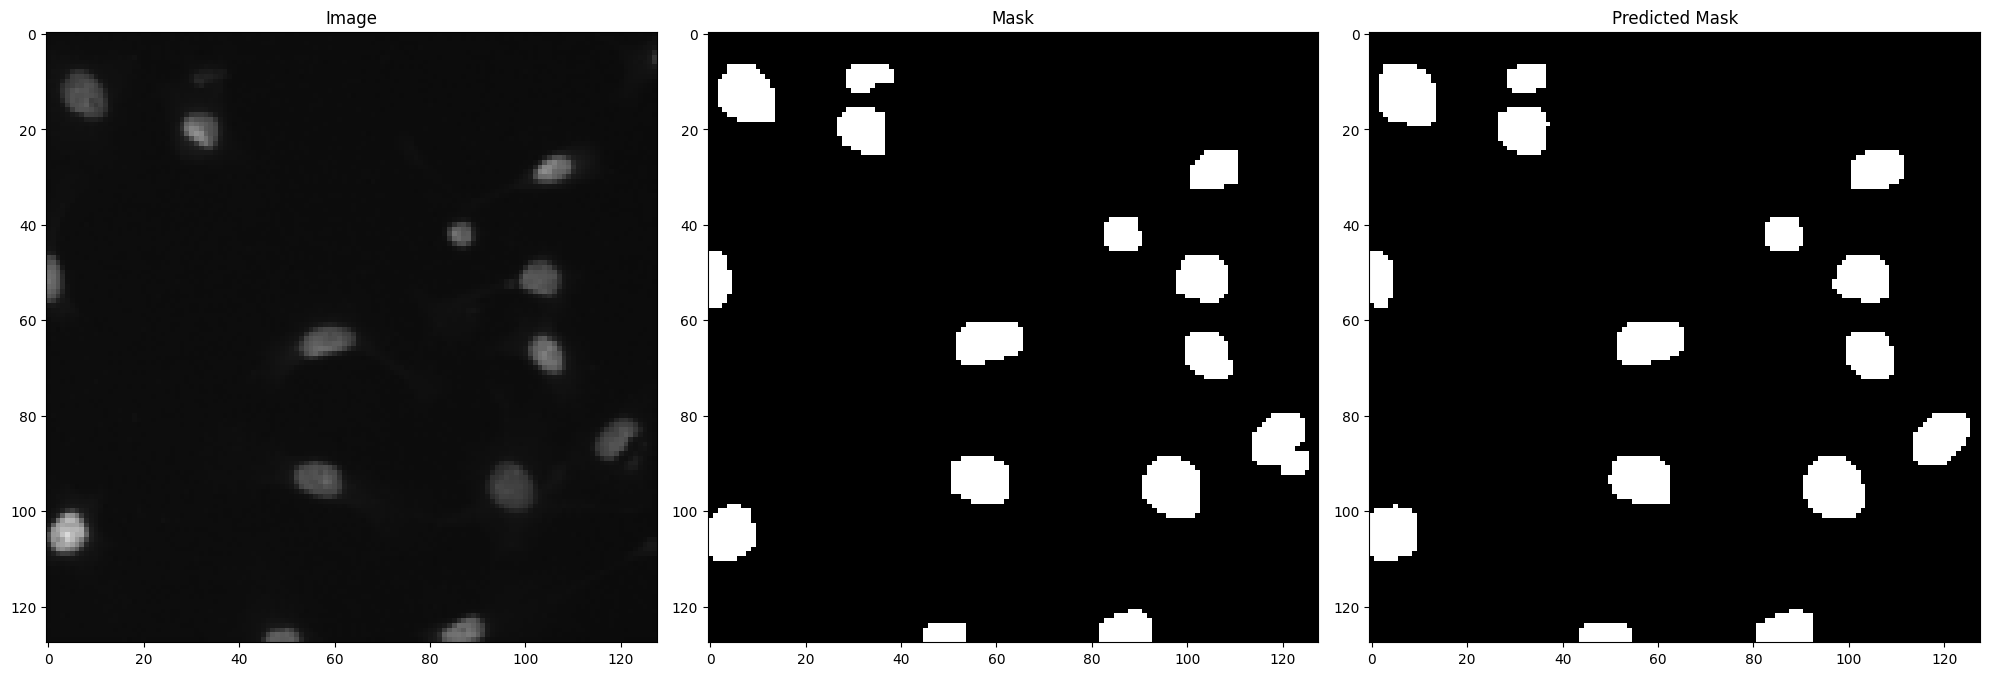

In [32]:
# Ploting our predicted masks
ix =random.randint(0, 602)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(131)
imshow(X_train[ix])
plt.title("Image")

# Our original combined mask
plt.subplot(132)
imshow(np.squeeze(Y_train[ix]))
plt.title("Mask")

# The mask our U-Net model predicts
plt.subplot(133)
imshow(np.squeeze(preds_train_t[ix] > 0.5))
plt.title("Predicted Mask")
plt.show()


### Showing our predicted masks on our validation data

<ipython-input-33-64a6bd52c577>:7: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(X_train[ix])
<ipython-input-33-64a6bd52c577>:13: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(np.squeeze(Y_train[ix] > 0.5))


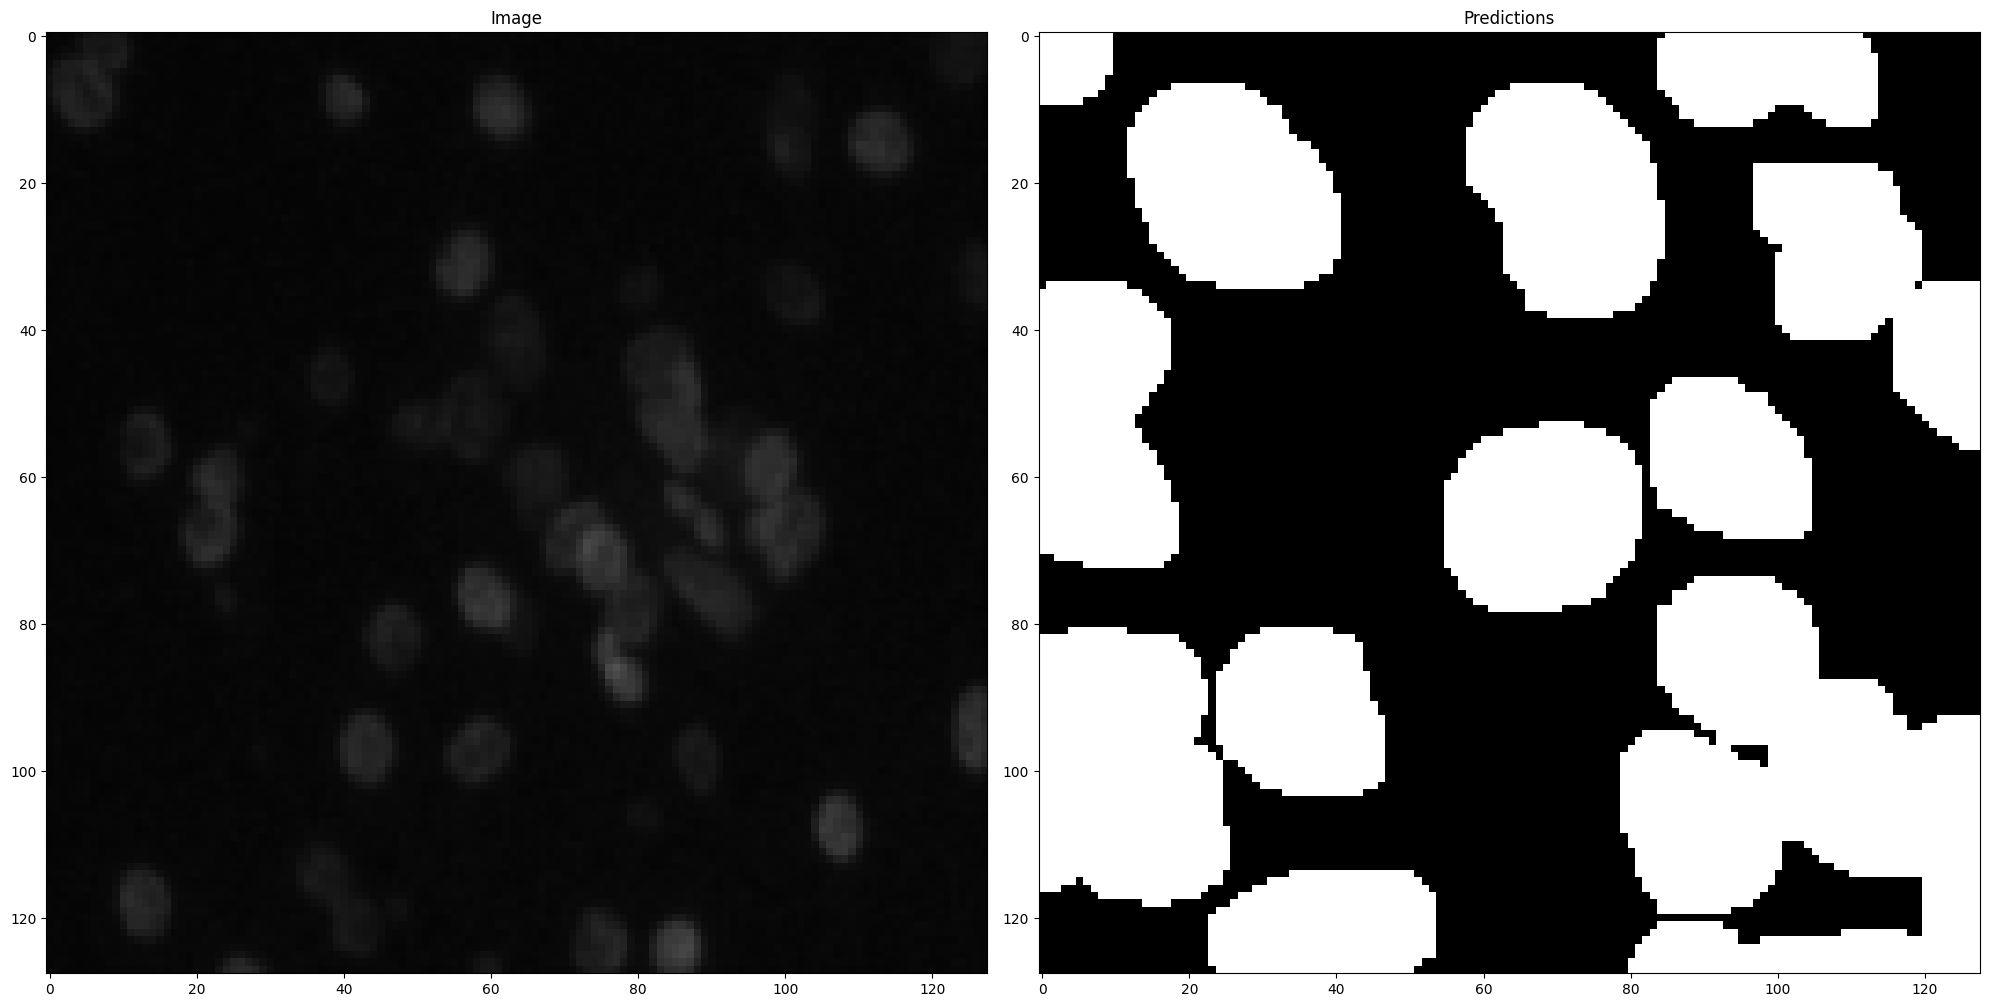

In [33]:
# Ploting our predicted masks
ix = random.randint(602, 668)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(121)
imshow(X_train[ix])
plt.title("Image")

# Our original combined mask
plt.subplot(122)
ix = ix - 603
imshow(np.squeeze(Y_train[ix] > 0.5))
plt.title("Predictions")
plt.show()